In [13]:
### FACIAL EMOTION RECOGNITION USING FER2013 DATASET ###
import pandas as pd
import cv2 as cv
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
import os
import glob
import tqdm
import matplotlib.pyplot as plt

In [2]:
### PREPARING FACIAL EMOTION DATASET ###
df = pd.read_csv('Resources/fer2013.csv')
CLASSES = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
           4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
df['emotion'].replace(CLASSES, inplace=True)
df['emotion'].value_counts()

emotion
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: count, dtype: int64

In [3]:
### SELECTING 500 FACES IN EACH CLASSES ###
dfs = []
for c in CLASSES.values():
    dfs.append(df[df['emotion'] == c].head(500))
df = pd.concat(dfs)
df['emotion'].value_counts()

emotion
Angry       500
Disgust     500
Fear        500
Happy       500
Sad         500
Surprise    500
Neutral     500
Name: count, dtype: int64

In [4]:
### CONVERTING STRING PIXELS TO NUMERICAL ###
fe_data = []
for row in df.values:
    e = row[0]
    pixels = list(map(int, row[1].split(' ')))
    fe_data.append(pixels + [e])
df = pd.DataFrame(fe_data, columns=[
    'P{0}'.format(v+1) for v in range(len(pixels))
] + ['Emotion'])
df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P2296,P2297,P2298,P2299,P2300,P2301,P2302,P2303,P2304,Emotion
0,70,80,82,72,58,58,60,63,54,58,...,182,183,136,106,116,95,106,109,82,Angry
1,151,150,147,155,148,133,111,140,170,174,...,108,95,108,102,67,171,193,183,184,Angry
2,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,Angry
3,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,Angry
4,8,9,14,21,26,32,37,46,52,62,...,74,75,74,80,91,101,103,122,130,Angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,65,58,49,50,53,45,46,46,80,90,...,89,80,86,141,152,143,143,135,129,Neutral
3496,59,58,38,30,24,13,24,9,14,19,...,19,19,6,36,126,111,88,93,114,Neutral
3497,52,44,33,67,102,92,42,33,28,35,...,37,41,36,30,28,25,12,12,14,Neutral
3498,53,41,39,36,36,25,30,27,19,27,...,151,152,150,150,140,128,108,73,99,Neutral


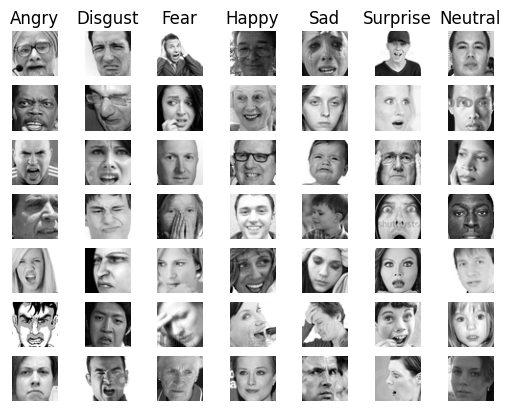

In [5]:
### DATA VISUALIZE ###
N_CLASSES = len(CLASSES)
fig, axes = plt.subplots(nrows=N_CLASSES, ncols=N_CLASSES)
for row in range(N_CLASSES):
    for col in range(N_CLASSES):
        pixels = df[df['Emotion'] == CLASSES[col]].values[
            row+1*col+1, :-1
        ]
        img = pixels.reshape((48, 48)).astype(np.uint8)
        axes[row][col].imshow(img, cmap='gray')
        axes[row][col].axis('off')
        if row == 0:
            axes[row][col].set_title(CLASSES[col])

In [6]:
### BUILDING DEEP LEARNING MODEL ###
INPUT_SIZE = (48, 48, 1)
model = Sequential(name='emotion_recognizer')
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                        input_shape=INPUT_SIZE))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "emotion_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)  

In [7]:
### PREPARING TRAIN DATA ###
from tensorflow.python.keras.utils.np_utils import to_categorical
df['Emotion'].replace({v: k for k, v in CLASSES.items()}, inplace=True)
x = df.values[:, :-1].reshape((len(df), *INPUT_SIZE))
x = x / 255.0
y = df.values[:, -1]
y_cat = to_categorical(y, N_CLASSES)
print('[INFO] Input Data Shape :: {0}'.format(x.shape))
print('[INFO] Output Data Shape :: {0}'.format(y_cat.shape))

[INFO] Input Data Shape :: (3500, 48, 48, 1)
[INFO] Output Data Shape :: (3500, 7)


In [8]:
### COMPILING MODEL FOR TRAINING ###
model.compile(
    optimizer=RMSProp(), loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
### MODEL TRAINING ###
import tensorflow as tf
tf.config.run_functions_eagerly(True)
model.fit(
    x, y_cat, epochs=100, batch_size=32, validation_split=0.3,
)

c:\Users\RaviKumar\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
77/77 [==============================] - 12s 65ms/step - loss: 1.7186 - accuracy: 0.2020 - val_loss: 3.7232 - val_accuracy: 0.0000e+00
Epoch 2/100
77/77 [==============================] - 5s 59ms/step - loss: 1.6310 - accuracy: 0.1922 - val_loss: 6.2524 - val_accuracy: 0.0000e+00
Epoch 3/100
77/77 [==============================] - 5s 59ms/step - loss: 1.6087 - accuracy: 0.2482 - val_loss: 8.0884 - val_accuracy: 0.0048
Epoch 4/100
77/77 [==============================] - 5s 61ms/step - loss: 1.5367 - accuracy: 0.3294 - val_loss: 7.2721 - val_accuracy: 0.0410
Epoch 5/100
77/77 [==============================] - 5s 66ms/step - loss: 1.4563 - accuracy: 0.3829 - val_loss: 12.7061 - val_accuracy: 0.0171
Epoch 6/100
77/77 [==============================] - 5s 60ms/step - loss: 1.3961 - accuracy: 0.4086 - val_loss: 18.4643 - val_accuracy: 0.0133
Epoch 7/100
77/77 [==============================] - 4s 58ms/step - loss: 1.3427 - accuracy: 0.4457 - val_loss: 15.5302 - val_accuracy: 0

In [11]:
### SAVING MODEL TO FILE ###
model.save('Resources/model.h5')

In [12]:
### LOADING PRE-TRAINED MODEL FROM SAVED FILE ###
from keras.models import load_model
model = load_model('Resources/model.h5')
model.summary()

Model: "emotion_recognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                            

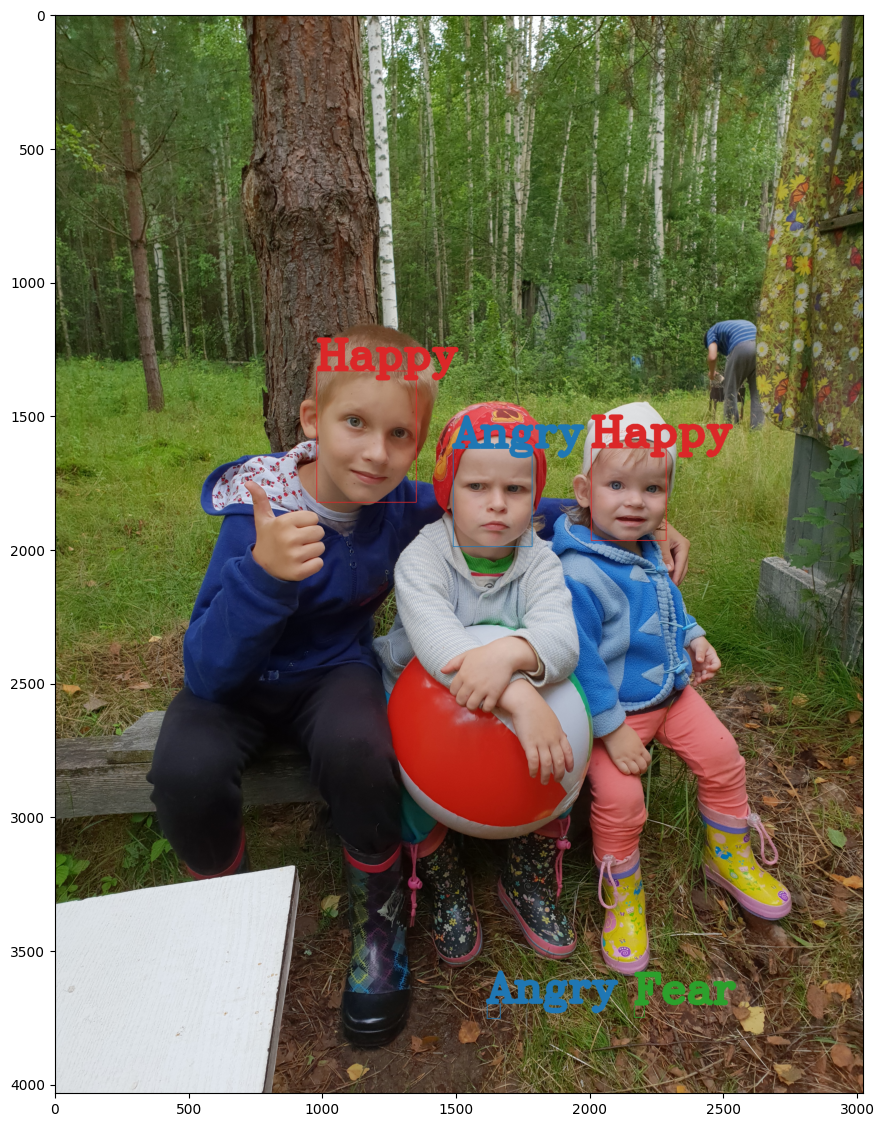

In [10]:
### PREDICTION USING TRAINED MODEL ###
import matplotlib.pyplot as plt
import mtcnn
mtcnn_model = mtcnn.MTCNN()
colors = [(31, 119, 180), (255, 127, 14), (44, 160, 44), (219, 39, 40),
          (148, 103, 189), (140, 86, 75), (227, 119, 194)]

img = cv.imread('Resources/Photos/boys.jpg')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
boxes = mtcnn_model.detect_faces(img_rgb)
faces = []
for box in boxes:
    x, y, w, h = box['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv.cvtColor(
        cv.resize(face, INPUT_SIZE[:-1]), cv.COLOR_RGB2GRAY
    )
    faces.append(face)
data = np.array(faces).reshape(len(faces), *INPUT_SIZE)
data = data / 255.0
scores = model.predict(data)
class_idx = np.argmax(scores, axis=1)
for idx, box in zip(class_idx, boxes):
    x, y, w, h = box['box']
    cv.rectangle(img_rgb, (x, y), (x+w, y+h), colors[idx], 2)
    cv.putText(img_rgb, CLASSES[idx], (x, y-10),
               cv.FONT_HERSHEY_COMPLEX, 5, colors[idx], 20)
plt.figure(figsize=(14, 14))
plt.imshow(img_rgb)